In [1]:
import os, sys
sys.path.append("/content")
from src.utils import fit_mlp, plot_obs_predict

with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}


In [239]:
# Specify hyperparameters and fit model
buffer_distance = 500
day_tolerance = 8
cloud_thr = 80
features = [
    "sentinel-2-l2a_AOT", 
    "sentinel-2-l2a_B02", "sentinel-2-l2a_B03", "sentinel-2-l2a_B04", # RGB bands
    "sentinel-2-l2a_B08", # NIR
    #"sentinel-2-l2a_WVP", 
    "sentinel-2-l2a_B05", "sentinel-2-l2a_B06", "sentinel-2-l2a_B07", "sentinel-2-l2a_B8A",  # Red edge bands
    # "is_brazil", #"sine_julian", 
    "sentinel-2-l2a_B11", "sentinel-2-l2a_B12", # SWIR
    # "mean_viewing_azimuth", "mean_viewing_zenith",
    # "mean_solar_azimuth", "mean_solar_zenith"
]
epochs = 1000
batch_size = 64
learning_rate = 0.005

layer_out_neurons = [8, 12, 6]

buffer_distance = 500
day_tolerance = 8
cloud_thr = 80
mask_method1 = "lulc"
mask_method2 = "mndwi"
min_water_pixels = 20
learn_sched_step_size = 200 
learn_sched_gamma = 0.2

In [240]:
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

n_layers = len(layer_out_neurons)

# Read the data
fp = f"/content/local/partitioned_feature_data_buffer500m_daytol8_cloudthr80percent_lulcmndwi_masking_tmp.csv"
data = pd.read_csv(fp)

data = data[data["partition"] != "testing"]

In [241]:
data["Log SSC (mg/L)"] = np.log(data["SSC (mg/L)"])
response = "Log SSC (mg/L)"
not_enough_water = data["n_water_pixels"] < min_water_pixels
data.drop(not_enough_water[not_enough_water].index, inplace=True)
lnssc_0 = data["Log SSC (mg/L)"] == 0
data.drop(lnssc_0[lnssc_0].index, inplace=True)


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[features])
# X_scaled = np.concatenate([np.full((X_scaled.shape[0], 1), 1.), X_scaled], 1)
# print(np.full((X_scaled.shape[0], 1), 1.).shape)
# print(X_scaled.shape)

In [245]:
val_mse = []
fold_n_sites = []

val_pred_fold = []
train_pred_fold = []
val_loss_fold = []
train_loss_fold = []
y_val_fold = []
y_train_fold = []

for fold in [1, 2, 3]:
    X_train = X_scaled[data["fold_idx"] != fold]
    y_train = data[data["fold_idx"] != fold][response]
    X_val = X_scaled[data["fold_idx"] == fold]
    y_val = data[data["fold_idx"] == fold][response]
    site_val = list(data[data["fold_idx"] == fold]["site_no"])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    class RegressionDataset(Dataset):

        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]

        def __len__ (self):
            return len(self.X_data)

    train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())

    num_features = X_train.shape[1]

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    train_loader_all = DataLoader(dataset=train_dataset, batch_size=1)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    global MultipleRegression
    class MultipleRegression(nn.Module):
        def __init__(self, num_features, n_layers, layer_out_neurons):
            super(MultipleRegression, self).__init__()
            self.n_layers = n_layers
            self.layer_out_neurons = layer_out_neurons

            most_recent_n_neurons = layer_out_neurons[0]
            self.layer_1 = nn.Linear(num_features, layer_out_neurons[0])

            for i in range(2, n_layers + 1):
                setattr(
                    self,
                    f"layer_{i}",
                    nn.Linear(layer_out_neurons[i-2], layer_out_neurons[i-1])
                )
                most_recent_n_neurons = layer_out_neurons[i-1]

            self.layer_out = nn.Linear(most_recent_n_neurons + 1, 1)
            self.relu = nn.ReLU()


        def forward(self, inputs):
            x = self.relu(self.layer_1(inputs))
            for i in range(2, self.n_layers + 1):
                x = self.relu(getattr(self, f"layer_{i}")(x))

            bias = torch.full((x.shape[0], 1), 1.)
            x = self.layer_out(torch.cat((bias, x), 1))

            return (x)


    model = MultipleRegression(num_features, n_layers, layer_out_neurons)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=learn_sched_step_size,
        gamma=learn_sched_gamma
    )

    loss_stats = {
        "train": [],
        "val": []
    }

    # Train the model
    print("Begin training.")
    for e in range(1, epochs+1):
        # TRAINING
        train_epoch_loss = 0
        model.train()

        for X_train_batch, y_train_batch in train_loader:
            # grab data to iteration and send to CPU
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            def closure():
                # Zero gradients
                optimizer.zero_grad()
                # Forward pass
                y_train_pred = model(X_train_batch)
                # Compute loss
                train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
                # Backward pass
                train_loss.backward()

                return train_loss

            # Update weights
            optimizer.step(closure)

            # Update the running loss
            train_loss = closure()
            train_epoch_loss += train_loss.item()

        val_pred = [] 
        
        with torch.no_grad():
            model.eval()
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_pred = model(X_batch).cpu().squeeze().tolist()#.numpy()
                val_pred.append(y_pred)

        val_pred = np.array(val_pred)
        val_se = list((val_pred - y_val)**2)

        group_means = [np.mean(val_se[site_val == a]) for a in np.unique(site_val)]
        val_loss_site = np.mean(group_means)
        val_loss = np.mean(val_se)
        loss_stats["val"].append(val_loss)
        loss_stats["train"].append(train_epoch_loss/len(train_loader))

        scheduler.step()

        if (e % 50 == 0):
            print(f"Epoch {e}/{epochs} | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss (mean of sites): {val_loss_site:.5f} | Val Loss (pooled mean): {val_loss:.5f}")
    
    train_pred_list = []

    with torch.no_grad():
        model.eval()
        for X_batch, _ in train_loader_all:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().squeeze().tolist()
            train_pred_list.append(y_pred)

    val_pred_list = []

    with torch.no_grad():
        model.eval()
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().squeeze().tolist()
            val_pred_list.append(y_pred)

    val_pred = np.array(val_pred_list)
    val_se = list((val_pred - y_val)**2)
    group_means = [np.mean(val_se[site_val == a]) for a in np.unique(site_val)]

    
    val_mse.append(np.mean(group_means))
    fold_n_sites.append(len(np.unique(site_val)))

    val_pred_fold.append(val_pred_list)
    val_loss_fold.append(loss_stats["val"])
    y_val_fold.append(list(y_val))

    train_pred_fold.append(train_pred_list)
    train_loss_fold.append(loss_stats["train"])
    y_train_fold.append(list(y_train))


output = {
    "buffer_distance": buffer_distance,
    "day_tolerance": day_tolerance,
    "cloud_thr": cloud_thr,
    "min_water_pixels": min_water_pixels,
    "features": features,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "layer_out_neurons": layer_out_neurons,
    "epochs": epochs,
    "val_mse": np.average(val_mse, weights=fold_n_sites)
}


Begin training.
Epoch 50/1000 | Train Loss: 0.55547 | Val Loss (mean of sites): 1.34527 | Val Loss (pooled mean): 0.91875
Epoch 100/1000 | Train Loss: 0.39111 | Val Loss (mean of sites): 0.74384 | Val Loss (pooled mean): 0.84499
Epoch 150/1000 | Train Loss: 0.42910 | Val Loss (mean of sites): 0.20773 | Val Loss (pooled mean): 0.75228
Epoch 200/1000 | Train Loss: 0.42937 | Val Loss (mean of sites): 0.55995 | Val Loss (pooled mean): 0.79330
Epoch 250/1000 | Train Loss: 0.36160 | Val Loss (mean of sites): 0.32428 | Val Loss (pooled mean): 0.75598
Epoch 300/1000 | Train Loss: 0.39801 | Val Loss (mean of sites): 0.31830 | Val Loss (pooled mean): 0.75666
Epoch 350/1000 | Train Loss: 0.39061 | Val Loss (mean of sites): 0.32117 | Val Loss (pooled mean): 0.75749
Epoch 400/1000 | Train Loss: 0.36524 | Val Loss (mean of sites): 0.33310 | Val Loss (pooled mean): 0.75473
Epoch 450/1000 | Train Loss: 0.34934 | Val Loss (mean of sites): 0.27779 | Val Loss (pooled mean): 0.74645
Epoch 500/1000 | Train

In [246]:
val_mse

[0.31087168281166105, 12.233973628567849, 0.05423578798028172]

R2: 0.34532182636921327


,site_no,se
0,22700000,0.310872
1,23100000,3.012120
2,23100000,0.003772
3,25200000,3.482009
4,25200000,9.097847
...,...,...
370,07182510,0.073086
371,07182510,0.006382
372,07182510,0.017752
373,07182510,0.037984


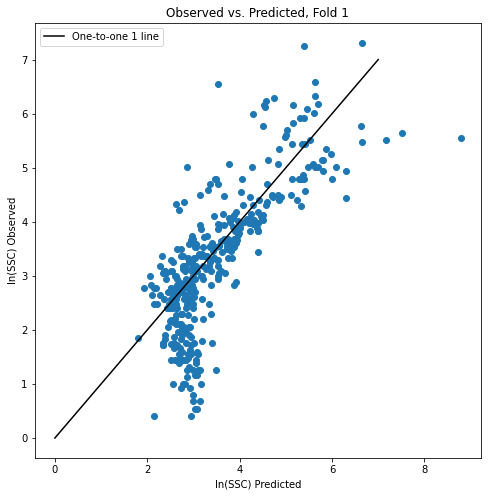

In [248]:
part = "validation"
my_fold = 0

if part == "validation":
    pred_fold = val_pred_fold
    y_fold = y_val_fold
else:
    pred_fold = train_pred_fold
    y_fold = y_train_fold

print(f"R2: {r2_score(pred_fold[my_fold], y_fold[my_fold])}")
plot_obs_predict(pd.DataFrame({"pred": pred_fold[my_fold], "obs": y_fold[my_fold]}), f"Observed vs. Predicted, Fold {my_fold+1}")
pd.DataFrame({
    "site_no": list(data[data["fold_idx"] == my_fold + 1]["site_no"]),
    "se": (np.array(y_fold[my_fold]) - np.array(pred_fold[my_fold])) ** 2
})
# list(data[data["fold_idx"] == my_fold + 1]["site_no"])

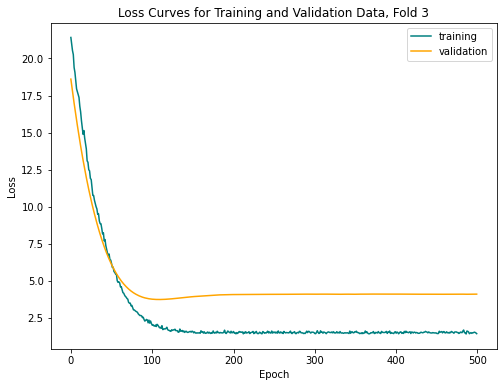

In [130]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_loss_fold[my_fold], color="teal", label="training")
plt.plot(val_loss_fold[my_fold], color="orange", label="validation")
plt.title(f"Loss Curves for Training and Validation Data, Fold {my_fold + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()


In [225]:
np.array([1,2,3,4]) * np.array([1,2,3,4])

array([ 1,  4,  9, 16])